In [5]:
import pickle
import os
import torch
import torch.nn as nn
import time

## load the data

In [2]:
root = "/home/chaoqiy2/data/MNIST/Spatio-temporal/"
claim_tensor = torch.Tensor(
    pickle.load(open(os.path.join(root, "claim_tensor.pkl"), "rb"))
)
county_tensor = torch.Tensor(
    pickle.load(open(os.path.join(root, "county_tensor.pkl"), "rb"))
)
covid_tensor = torch.Tensor(
    pickle.load(open(os.path.join(root, "covid_tensor.pkl"), "rb"))
)
distance_mat = torch.Tensor(
    pickle.load(open(os.path.join(root, "distance_mat.pkl"), "rb"))
)
hos_tensor = torch.Tensor(pickle.load(open(os.path.join(root, "hos_tensor.pkl"), "rb")))
mob_mat = torch.Tensor(pickle.load(open(os.path.join(root, "mob_mat.pkl"), "rb")))
vac_tensor = torch.Tensor(pickle.load(open(os.path.join(root, "vac_tensor.pkl"), "rb")))

feat_name = pickle.load(open(os.path.join(root, "feat_name.pkl"), "rb"))

## combine the data

In [40]:
device = "cuda:0"
demographs = county_tensor
cty_day_feat = torch.cat(
    [claim_tensor, covid_tensor.unsqueeze(-1), hos_tensor, vac_tensor], dim=-1
).to(device)
graph1 = distance_mat.to(device)
graph2 = mob_mat.to(device)

print(demographs.shape, cty_day_feat.shape, graph1.shape, graph2.shape)

torch.Size([2334, 14]) torch.Size([2334, 639, 59]) torch.Size([2334, 2334]) torch.Size([2334, 2334])


## optimize

In [157]:
def optimize(A, B, D, reg=1e-8):
    u = torch.linalg.solve(A + reg * D, B)
    return u

def CPD(T, R, graph, Lambda, iteration=50, device="cuda:0", A1=None, A2=None, A3=None):
    # preparation
    loss_list = []
    d1, d2, d3 = T.shape

    if A1 is None:
        A1 = torch.randn(d1, R).to(device)
        A2 = torch.randn(d2, R).to(device)
        A3 = torch.randn(d3, R).to(device)
    
    D = torch.eye(R).to(device)
    
    # ALS 
    tic = time.time()
    for i in range(iteration):

        # sub-iteration
        if i > 10:
            A1_ = A1.clone()
            loss = []
            for j in range(1):
                A1 = optimize((A3.T@A3)*(A2.T@A2), torch.einsum('ijk,jr,kr->ri',T,A2,A3) - \
                              Lambda * A1.T@graph, D).T
                loss.append((torch.norm(A1 - A1_) / torch.norm(A1_)).item())
                A1_ = A1.clone()
#             print ("A precision:", loss)
        else:
            A1 = optimize((A3.T@A3)*(A2.T@A2), torch.einsum('ijk,jr,kr->ri',T,A2,A3), D).T
            A2 = optimize((A1.T@A1)*(A3.T@A3), torch.einsum('ijk,ir,kr->rj',T,A1,A3), D).T
            A3 = optimize((A1.T@A1)*(A2.T@A2), torch.einsum('ijk,ir,jr->rk',T,A1,A2), D).T

        # loss 
        rec = torch.einsum('ir,jr,kr->ijk',A1,A2,A3)
        loss1 = torch.norm(rec - T) / torch.norm(T)
        loss2 = torch.trace(A1.T@graph@A1)
        if i % 10 == 9:
            print ('{}/{}'.format(i, iteration), 'loss1:', loss1.item(), 'loss2:', loss2.item(), 'time span:', time.time() - tic)

        # collect loss
        tic = time.time() 
        loss_list.append((loss1+loss2).item())

    return A1, A2, A3, loss_list


def get_laplacian(A, normalized=True):
    # -------------------------------
    # calculate the laplacian
    A = torch.Tensor(A)
    D = A.sum(axis=1)
    if normalized:
        D_rev = torch.diag(D ** (-0.5))
        L = torch.eye(len(D)) - D_rev @ A @ D_rev
    else:
        L = torch.diag(D) - A
    L = L.to(device)
    # ---------------------------------
    return L

dis_laplacian = get_laplacian(distance_mat)
mob_laplacian = get_laplacian(mob_mat)
graph = - 1e-1 * dis_laplacian + 1 * mob_laplacian 

## normalize the tensor

In [158]:
MEAN = torch.mean(cty_day_feat, dim=(0,1), keepdim=True)
STD = torch.std(cty_day_feat, dim=(0,1), keepdim=True)
new_T = cty_day_feat / MEAN

In [159]:
# A1 = torch.randn(2334, 5)
# A2 = torch.randn(639, 5)
# A3 = torch.randn(59, 5)
# T = torch.einsum("ir,jr,kr->ijk",A1,A2,A3)
# MEAN = torch.mean(T, dim=(0,1), keepdim=True)
# STD = torch.std(T, dim=(0,1), keepdim=True)
# new_T = ((T - MEAN) / STD).to(device)


In [165]:
A1, A2, A3, loss_list = CPD(cty_day_feat, graph=graph, Lambda=1e3, R=5, iteration=50, device=device)

9/50 loss1: 0.05293762683868408 loss2: 814290.0 time span: 0.02203845977783203
19/50 loss1: 0.052398793399333954 loss2: 835749.625 time span: 0.007366180419921875
29/50 loss1: 0.052398793399333954 loss2: 835749.625 time span: 0.0073757171630859375
39/50 loss1: 0.052398793399333954 loss2: 835749.625 time span: 0.007353782653808594
49/50 loss1: 0.052398793399333954 loss2: 835749.625 time span: 0.0073697566986083984


## dump out the data

In [176]:
import pickle
import numpy as np
pickle.dump(A1.cpu().numpy(), open("decomp.pkl", "wb"))

/tmp/ipykernel_34903/2022746450.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(-A1[:, 1].cpu().numpy()))


(array([  3.,   6.,  53., 242., 338., 525., 521., 284.,  91.,  13.]),
 array([-11.691273 , -10.084544 ,  -8.477816 ,  -6.871086 ,  -5.2643576,
         -3.6576288,  -2.0509   ,  -0.4441712,   1.1625576,   2.7692864,
          4.376015 ], dtype=float32),
 <BarContainer object of 10 artists>)

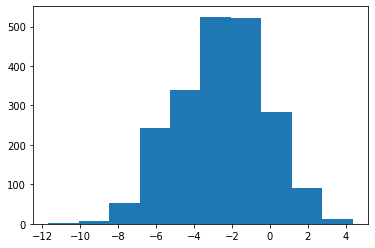

In [181]:
plt.hist(np.log(-A1[:, 1].cpu().numpy()))

In [184]:
[item for item in np.exp([-11.691273 , -10.084544 ,  -8.477816 ,  -6.871086 ,  -5.2643576,
         -3.6576288,  -2.0509   ,  -0.4441712,   1.1625576,   2.7692864,
          4.376015 ])]

[8.366516072160513e-06,
 4.171941291326946e-05,
 0.00020803255002531403,
 0.0010373498906893798,
 0.0051727149132769325,
 0.025793602059426626,
 0.1286190942965734,
 0.641355611347234,
 3.1981022915471025,
 15.947249990865679,
 79.52051192370948]